# Assessing specificity of model generated explanations
Author: Katja Kamyshanova

-----------
The code below calculates the specificity for verbs, nouns, and adjectives in the generated explanations made by Qwen2-VL and then creates the scatterplots for the resulted concreteness/specificity distribution. To run this code, the code requires the concreteness scores calculated in `calculate_concreteness.ipynb`.

Refer to the README file on GitHub for further information and implementation: https://github.com/katjaaaaaa/ms_thesis



# Prepare the environment

In [1]:
# Connect to drive
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [2]:
HEAD_DIR = "/content/gdrive/MyDrive/MS_postprocess_code/specificity"

In [9]:
# The files represent the subsets taken from the Qwen2-VL output in katjaaaaaa/ms_thesis/test_final/six-shot/few-shot_5065_154_7879_2_5004_78_071436_28_06_2025_plo_test.json
# These files can be found in 'katjaaaaaa/ms_thesis/test_final/best-model-final/.' on the GitHub
input_files = [
               "negation_features_true_positive_concrete",
               "negation_features_false_positive_concrete",
               "negation_features_false_negative_concrete",
               "negation_features_true_negative_concrete",
               ]

In [ ]:
!pip install nltk
!pip install numpy

Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/cli/base_command.py", line 179, in exc_logging_wrapper
    status = run_func(*args)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/cli/req_command.py", line 67, in wrapper
    return func(self, options, args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/commands/install.py", line 447, in run
    conflicts = self._determine_conflicts(to_install)
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/commands/install.py", line 578, in _determine_conflicts
    return check_install_conflicts(to_install)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/operations/check.py", line 101, in check_install_conflicts
    package_set, _ = create_package_set_from_installed()
              

In [3]:
import nltk
nltk.download('wordnet')


[nltk_data] Downloading package wordnet to /root/nltk_data...


True

# Specificity calculation functions

## Adjective Specificity
The code is adapted from Schreiter (2024)

In [4]:
from nltk.corpus import wordnet as wn
import numpy as np
import json

In [5]:
def calculate_adjective_specificity(adjective):
    """
    Calculates the specificity score of an adjective
    """
    synsets = wn.synsets(adjective, pos=wn.ADJ)
    #print(synsets)
    if synsets:
        lemmas = set()
        antonyms = set()
        total_ssw = 0
        for synset in synsets:
            lemma_names = synset.lemma_names()
            for lemma in lemma_names:
                lemmas.add(lemma) ## crawls all lemmas of all synsets corresponding to the adjective
            for lemma in synset.lemmas():
                for antonym in lemma.antonyms():
                    antonyms.add(antonym) ## crawls all antonyms if all synsets and lemmas corresponding to the adjective
            ssw = sum(len(similar.lemmas()) for similar in synset.similar_tos()) ## Counts all semantic-similar synsets of the adjective
            total_ssw += ssw

        synonym_set_size = len(lemmas)
        antonym_number = len(antonyms)
        total_number_of_cluster = total_ssw + antonym_number + synonym_set_size
        if total_ssw != 0 or antonym_number != 0 or synonym_set_size != 0:
            specificity_score = 1/np.log(1+total_number_of_cluster+len(synsets)) ## Calculates the specificity score
        else:
            specificity_score = float("inf")
        return specificity_score
    # else: return f"There are no synsets for the adjective: {adjective}"
    else: return None

In [ ]:
calculate_adjective_specificity("beautiful")

[Synset('beautiful.a.01'), Synset('beautiful.s.02')]


np.float64(0.28599966750267436)

## Noun Specificity

The code is adapted from specificity3.py by Bolognesi et al. (2020)

The source code can be found [here](https://osf.io/sedgb)

In [6]:
import sys, os
import csv

In [7]:
def create_folder(filepath):
    directory = os.path.dirname(filepath)
    if not os.path.exists(directory):
        os.makedirs(directory)


def read_ratings(inputf):

    ratings_nouns = {}
    with open(inputf, 'r') as fratings:
        fratings = csv.reader(fratings, delimiter='\t')
        next(fratings)
        for row in fratings:
            if row[8] == "Noun":
                rating_score = row[2].replace(',', '.')
                ratings_nouns[row[0]] = float(rating_score)

    return ratings_nouns

def wn_closure(noun, score):

    first_sense = wn.synsets(noun, pos='n')[0]

    """
    Get hypernym closures
    """

    hypernym_closure = lambda s:s.hypernyms()

    inherited_hypernyms = {}
    inherited_hypernyms[(first_sense, len(list(first_sense.closure(hypernym_closure))),)] = list(first_sense.closure(hypernym_closure))

    """
    Get hypernyms based on instance of relations
    """

    for synset, hyper_list in inherited_hypernyms.copy().items():
        if synset[1] == 0:
            hypo_instance_of = synset[0].instance_hypernyms()
            if len(hypo_instance_of) > 0:
                inherited_hypernyms.pop(synset, None)
                inherited_hypernyms[(synset[0], len(list(hypo_instance_of[0].closure(hypernym_closure))),)] = list(
                    hypo_instance_of[0].closure(hypernym_closure))
        else:
            continue

    """
    Depth from Entity node
    """
    depth_measure = {}
    for synset_depth_val, list_hypern in  inherited_hypernyms.items():
        depth_measure[noun] = float(synset_depth_val[1])

    """
    Group scores for correlations
    """
    group_scores = {}
    final_scores = {}

    for entry, values in depth_measure.items():
        # group_scores[entry] = (keywords[entry], values,)
        group_scores[entry] = (score, values,)

    for entry, scores in group_scores.items():
        human_judgement, depth = scores
        ladder = float(depth * 5) / float(20) # 20 is the max.depht (or max distance from entity node) in WN30
        # final_scores[entry] = (human_judgement, depth, ladder) We don't need human judgement score as it is already stated in concreteness
        final_scores[entry] = (depth, ladder)


    return final_scores

## Verb Specificity
The code is adapted from specificity1.py by Bolognesi et al. (2020)

The source code can be found [here](https://osf.io/9m5wq)

In [8]:
import math

def spec1_verb(verb, score, total_verb_taxonomy):

    first_sense = wn.synsets(verb, pos='v')[0]

    """
    Get hypernym and hyponym closures
    """

    hypernym_closure = lambda s:s.hypernyms()
    hyponym_closure = lambda s:s.hyponyms()


    inherited_hypernyms = {}
    inherited_hyponyms = {}

    inherited_hypernyms[(first_sense, len(list(first_sense.closure(hypernym_closure))),)] = list(first_sense.closure(hypernym_closure))
    inherited_hyponyms[(first_sense, len(list(first_sense.closure(hyponym_closure))),)] = list(first_sense.closure(hyponym_closure))

    """
    Get hypernyms and hyponyms based on instance of relations
    """

    for synset, hyper_list in inherited_hypernyms.items():
        if synset[1] == 0:
            hypo_instance_of = synset[0].instance_hypernyms()
            if len(hypo_instance_of) > 0:
                inherited_hypernyms.pop(synset, None)
                inherited_hypernyms[(synset[0], len(list(hypo_instance_of[0].closure(hypernym_closure))),)] = list(
                    hypo_instance_of[0].closure(hypernym_closure))
        else:
            continue

    for synset, hypo_list in inherited_hyponyms.items():
        if synset[1] == 0:
            hypo_instance_of = synset[0].instance_hyponyms()
            if len(hypo_instance_of) > 0:
                inherited_hyponyms.pop(synset, None)
                inherited_hyponyms[(synset[0], len(list(hypo_instance_of[0].closure(hyponym_closure))),)] = list(
                    hypo_instance_of[0].closure(hyponym_closure))
            else:
                continue

    """
    hyponym distance from target word
    Resnik 1995 - via Iliev & Axeldorn 2017
    Inclusiveness = -log ((1+n)/N): n = number of hyponyms; N = number of nominal nodes in the taxonomy
    """
    genericity_measure = {}
    #print(inherited_hyponyms)
    for first_sense_tot_hypo, closure_firts_sense_list in inherited_hyponyms.items():
        genericity_score_resnik = -math.log2((1+len(closure_firts_sense_list))/total_verb_taxonomy)
        genericity_measure[verb] = genericity_score_resnik

    """
    Depth from Entity node
    """
    depth_measure = {}
    #print(inherited_hypernyms)
    for synset_depth_val, list_hypern in  inherited_hypernyms.items():
        depth_measure[verb] = float(synset_depth_val[1])


    """
    Group scores for correlations
    """
    group_scores = {}
    final_scores = {}


    for entry, values in depth_measure.items():
        group_scores[entry] = (score, values,)


    for entry, values in genericity_measure.items():
        new_val = group_scores[entry] + (values,)
        group_scores[entry] = new_val

    missing_hypernym_hyponyms = []


    for entry, scores in group_scores.items():
        human_judgement, depth, genericity = scores # genericity = log() part of the formula
        specificity_ladder = float(depth) + float(genericity) # final specificity score
        if specificity_ladder == 0.0:
            final_scores[entry] = None
        else:
            final_scores[entry] = (float(depth), float(genericity), specificity_ladder)


    return final_scores

In [ ]:
be_score = spec1_verb("speak", 2.541043290035166, float(len(list(wn.all_synsets(pos='v')))))
print(be_score)

{'speak': (3.0, 6.693644156632239, 9.693644156632239)}


# Calculate the specificity for the input files

In [10]:
def normalize_specificty(elem, spec_dict, spec_val):

    min_score = min(spec_val)
    max_score = max(spec_val)

    # final_scores = {}
    try:
        #print(spec_dict[elem])
        specificity = spec_dict[elem][-1]
        normalized_score = ((specificity - min_score) / (max_score - min_score)) * (5.0 - 1.0) + 1.0

    # catch the nouns unknown to wordnet and ignore them
    except KeyError:
        normalized_scre = None

    return normalized_score

In [13]:
def count_entries(conc, spec, word, data_dict, depth=None, generic=None):

    # Define the category
    if conc < 3 and spec < 3:
        categ = "abstract-generic"
    elif conc > 3 and spec < 3 :
        categ = "concrete-generic"
    elif conc < 3 and spec > 3 :
        categ = "abstract-specific"
    else:
        categ = "concrete-specific"

    # Add the word count to the dedicated category
    data_dict[categ]["count"] += 1
    data_dict[categ]["vals"][word] = data_dict[categ]["vals"].get(word, 0)
    data_dict[categ]["vals"][word] += 1

    # Save the depth and genericity scores for verbs
    if depth is not None:
        data_dict[categ]["depth"] = data_dict[categ].get("depth", [])
        data_dict[categ]["depth"].append(depth)
    if generic is not None:
        data_dict[categ]["genericity"] = data_dict[categ].get("genericity", [])
        data_dict[categ]["genericity"].append(generic)

    return data_dict

In [16]:
total_verb_taxonomy = float(len(list(wn.all_synsets(pos='v'))))

all_conc_nouns = []
all_conc_adj = []
all_conc_verb = []

all_spec_nouns = []
all_spec_adj = []
all_spec_verb = []

all_depth, all_generic = {}, {}
pos_depth, neg_depth = [], []
pos_generic, neg_generic = [], []
pos_spec, neg_spec = [], []

for i_file in input_files:
    with open(f"{HEAD_DIR}/data/{i_file}.json") as f:
        data_dict = json.load(f)

    # Create a dictionary for storing word examples per POS
    count_nouns = {}
    count_adj = {}
    count_verb = {}
    for i in ["concrete-generic", "abstract-generic","abstract-specific", "concrete-specific"]:
        count_nouns[i] = { "count" : 0, "vals" : dict()}
        count_adj[i] = { "count" : 0, "vals" : dict()}
        count_verb[i] = { "count" : 0, "vals" : dict()}

    # Create dictionary for storing the specificity
    wn_top_down_print = {}
    v_top_down_print = {}
    adj_top_down_print = {}

    # Collect specificity scores per word
    for _, data in data_dict.items():
        for k in ("zero-shot", "few-shot"):
            if k not in data:
                continue
            for vlm, answers in data[k].items():
                if isinstance(answers, dict):
                    for i, w in enumerate(answers["concreteness_words"]):
                        if w[2] >= 5:
                            w[2] = 5
                        elif w[2] <= 1:
                            w[2] = 1

                        if w[8] == "Verb":
                            wn_synsets = wn.synsets(w[0], pos='v')
                            if len(wn_synsets) >=1:
                                data_correlation = spec1_verb(w[0], w[2], total_verb_taxonomy)
                                if data_correlation[w[0]] != None:
                                    v_top_down_print[w[0]] = data_correlation[w[0]]

                        if w[8] == "Adjective":
                            spec_score = calculate_adjective_specificity(w[0])
                            if spec_score != None:
                                adj_top_down_print[w[0]] = (spec_score,)

                        elif w[8] == "Noun":
                            elem = w[0]
                            score = w[2]
                            wn_synsets = wn.synsets(elem, pos='n')
                            if len(wn_synsets) >=1:
                                data_correlation = wn_closure(elem, score)
                                wn_top_down_print.update(data_correlation)

    # Add up all calculated verb specificity scores
    spec_val_verb = []
    mean_depth = []
    mean_gener = []
    for k, v in v_top_down_print.items():
        depth, genericity, ladder = v
        spec_val_verb.append(float(ladder))
        mean_depth.append(float(depth))
        mean_gener.append(float(genericity))

    # Add up all calculated noun specificity scores
    spec_val_noun = []
    for k, v in wn_top_down_print.items():
        depth, specificity = v
        spec_val_noun.append(float(specificity))

    # Add up all calculated adjective specificity scores
    spec_val_adj = []
    for k, v in adj_top_down_print.items():
        specificity, = v
        spec_val_adj.append(float(specificity))

    conc_val_verb, spec_val_verb_final = [], []
    conc_val_noun, spec_val_noun_final = [], []
    conc_val_adj, spec_val_adj_final = [], []

    # Calculating normalized specificity scores
    for _, data in data_dict.items():
        for k in ("zero-shot", "few-shot"):
            if k not in data:
                continue
            for vlm, answers in data[k].items():
                if isinstance(answers, dict):
                    for i, w in enumerate(answers["concreteness_words"]):

                        if w[8] == "Verb" and w[0] in v_top_down_print:
                            normalized_score = normalize_specificty(w[0], v_top_down_print, spec_val_verb)
                            answers["concreteness_words"][i][5] = v_top_down_print[w[0]][0] # depth
                            answers["concreteness_words"][i][6] = v_top_down_print[w[0]][1] # genericity
                            answers["concreteness_words"][i][7] = normalized_score
                            count_verb = count_entries(w[2], w[7], w[0], count_verb, v_top_down_print[w[0]][0], v_top_down_print[w[0]][1])
                            conc_val_verb.append(w[2])
                            spec_val_verb_final.append(normalized_score)

                        if w[8] == "Noun" and w[0] in wn_top_down_print:
                            normalized_score = normalize_specificty(w[0], wn_top_down_print, spec_val_noun)
                            answers["concreteness_words"][i][6] = wn_top_down_print[w[0]][0] # depth
                            answers["concreteness_words"][i][7] = normalized_score
                            count_nouns = count_entries(w[2], w[7], w[0], count_nouns)
                            conc_val_noun.append(w[2])
                            spec_val_noun_final.append(normalized_score)

                        elif w[8] == "Adjective" and w[0] in adj_top_down_print:
                            normalized_score = normalize_specificty(w[0], adj_top_down_print, spec_val_adj)
                            answers["concreteness_words"][i][7] = normalized_score
                            conc_val_adj.append(w[2])
                            spec_val_adj_final.append(normalized_score)
                            count_adj = count_entries(w[2], w[7], w[0], count_adj)

    # Print the averaged specificity results
    print(f"FILE {i_file}\n")
    print(f"AVG SPECIFICITY VERBS: {round(np.mean(spec_val_verb_final), 4)} SD: {round(np.std(spec_val_verb_final), 4)} ")
    avg_spec = spec_val_noun_final + spec_val_adj_final
    print(f"AVG SPECIFICTY ADJ + NOUNS: {round(np.mean(avg_spec), 4)} SD: {round(np.std(avg_spec), 4)} ")
    print(f"AVG SPECIFICITY NOUNS: {round(np.mean(spec_val_noun_final), 4)} SD: {round(np.std(spec_val_noun_final), 4)}")
    print(f"AVG SPECIFICITY ADJECTIVES: {round(np.mean(spec_val_adj_final), 4)} SD: {round(np.std(spec_val_adj_final), 4)}")
    print()

    # Print the word examples per concreteness-specificity category
    for k, v in count_nouns.items():
        print(f"{k} verb count {count_verb[k]['count']}")
        print(f"{k} noun count {v['count']}")
        print(f"{k} adjective count {count_adj[k]['count']}")
        print(f"Verb examples: {sorted(count_verb[k]['vals'], key=count_verb[k]['vals'].get, reverse=True)[:15]}")
        print(f"Noun examples: {sorted(v['vals'], key=v['vals'].get, reverse=True)[:15]}")
        print(f"Adjective examples: {sorted(count_adj[k]['vals'], key=count_adj[k]['vals'].get, reverse=True)[:15]}")
        print()
    print("**********************************")

    all_conc_verb.append(conc_val_verb)
    all_conc_nouns.append(conc_val_noun)
    all_conc_adj.append(conc_val_adj)

    all_spec_verb.append(spec_val_verb_final)
    all_spec_nouns.append(spec_val_noun_final)
    all_spec_adj.append(spec_val_adj_final)

FILE negation_features_true_positive_concrete

AVG SPECIFICITY VERBS: 2.6669 SD: 0.6853 
AVG SPECIFICTY ADJ + NOUNS: 2.2424 SD: 0.5784 
AVG SPECIFICITY NOUNS: 2.3458 SD: 0.4741
AVG SPECIFICITY ADJECTIVES: 1.9127 SD: 0.7361

concrete-generic verb count 581
concrete-generic noun count 6849
concrete-generic adjective count 503
Verb examples: ['hold', 'appear', 'use', 'name', 'walk', 'base', 'sit', 'match', 'read', 'link', 'gather', 'win', 'play', 'cover', 'injure']
Noun examples: ['image', 'caption', 'news', 'outlet', 'world', 'snippet', 'person', 'entry', 'people', 'logo', 'player', 'text', 'scene', 'group', 'team']
Adjective examples: ['fake', 'blue', 'white', 'large', 'black', 'old', 'green', 'red', 'female', 'blonde', 'yellow', 'multiple', 'bottom', 'left', 'last']

abstract-generic verb count 3730
abstract-generic noun count 3259
abstract-generic adjective count 2794
Verb examples: ['be', 'mention', 'do', 'provide', 'relate', 'generate', 'refer', 'make', 'align', 'determine', 'includ

# Plot the concreteness/specificity distribution

In [ ]:
import matplotlib.pyplot as plt
import random

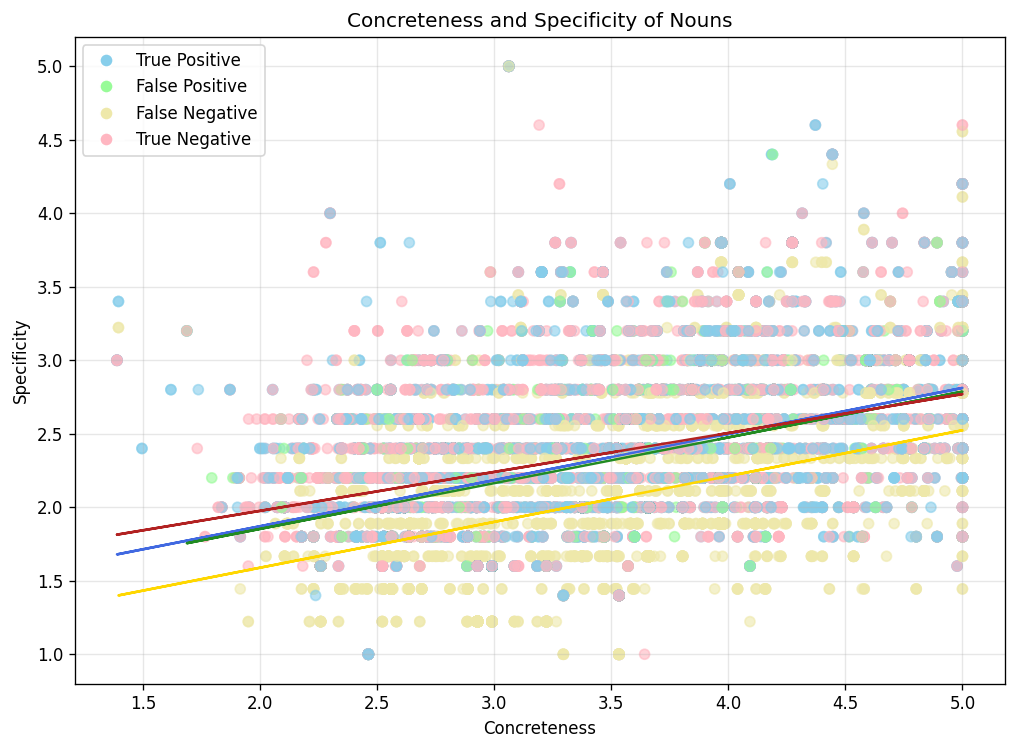

In [ ]:
data_names = ["True Positive", "False Positive", "False Negative", "True Negative"]
colors = ["skyblue", "palegreen", "palegoldenrod", "lightpink"]
colors_line = ["royalblue", "forestgreen", "gold", "firebrick"]

# Concatenate all class data
all_conc = np.concatenate(all_conc_nouns)
all_spec = np.concatenate(all_spec_nouns)
labels = np.concatenate([np.repeat(i, len(all_conc_nouns[i])) for i in range(4)])

# Shuffle indices
shuffle_idx = np.random.permutation(len(all_conc))

# Shuffle data and labels
shuffled_conc = all_conc[shuffle_idx]
shuffled_spec = all_spec[shuffle_idx]
shuffled_labels = labels[shuffle_idx]

# Map class indices to colors
color_map = np.array(colors)[shuffled_labels]

fig, ax = plt.subplots(figsize=(10, 7), dpi=120)

# Plot all points in one scatter, with colors assigned according to their class
sc = ax.scatter(shuffled_conc, shuffled_spec, c=color_map, alpha=0.6)

# Plot regression lines for each class
for i, dataset in enumerate(all_conc_nouns):
    m, b = np.polyfit(dataset, all_spec_nouns[i], 1)
    x_vals = np.array(dataset)
    ax.plot(x_vals, m * x_vals + b, c=colors_line[i])

# Create legend manually
handles = [plt.Line2D([0], [0], marker='o', color='w', label=data_names[i],
                      markerfacecolor=colors[i], markersize=8) for i in range(4)]
ax.legend(handles=handles)
ax.grid(True, alpha=0.3)

plt.xlabel("Concreteness", fontsize=10)
plt.ylabel("Specificity", fontsize=10)
plt.title("Concreteness and Specificity of Nouns")
plt.savefig(f"{HEAD_DIR}/conc_spec_nouns.pdf",bbox_inches="tight")
plt.show()

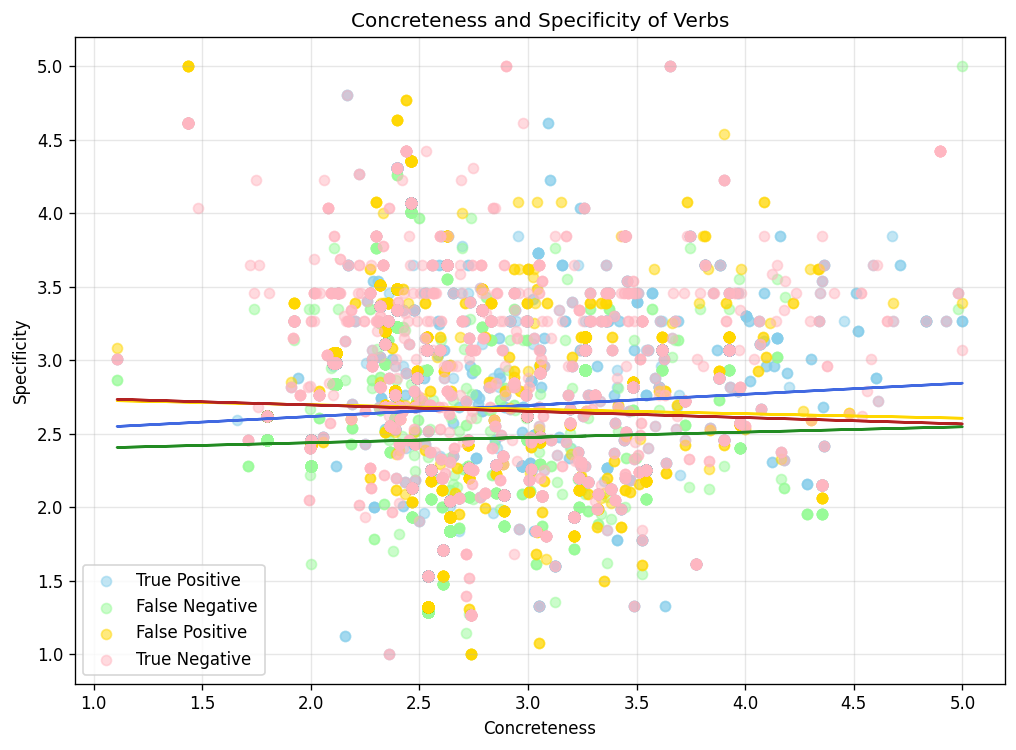

In [ ]:
data_names = ["True Positive", "False Negative", "False Positive", "True Negative"]
colors = ["skyblue", "palegreen", "gold", "lightpink"]
colors_line = ["royalblue", "forestgreen", "gold", "firebrick"]

fig, ax = plt.subplots(figsize=(10, 7), dpi=120)

for i, dataset in enumerate(all_conc_verb):
    m, b = np.polyfit(dataset, all_spec_verb[i], 1)
    ax.scatter(dataset, all_spec_verb[i], c=colors[i], label=data_names[i], alpha=0.5)
    ax.plot(dataset, m * np.array(dataset) + b, c=colors_line[i])

ax.legend()
ax.grid(True, alpha=0.3)

ax.set_xlabel("Concreteness", fontsize=10)
ax.set_ylabel("Specificity", fontsize=10)
ax.set_title("Concreteness and Specificity of Verbs")

plt.savefig(f"{HEAD_DIR}/conc_spec_verbs.pdf",bbox_inches="tight")
plt.show()

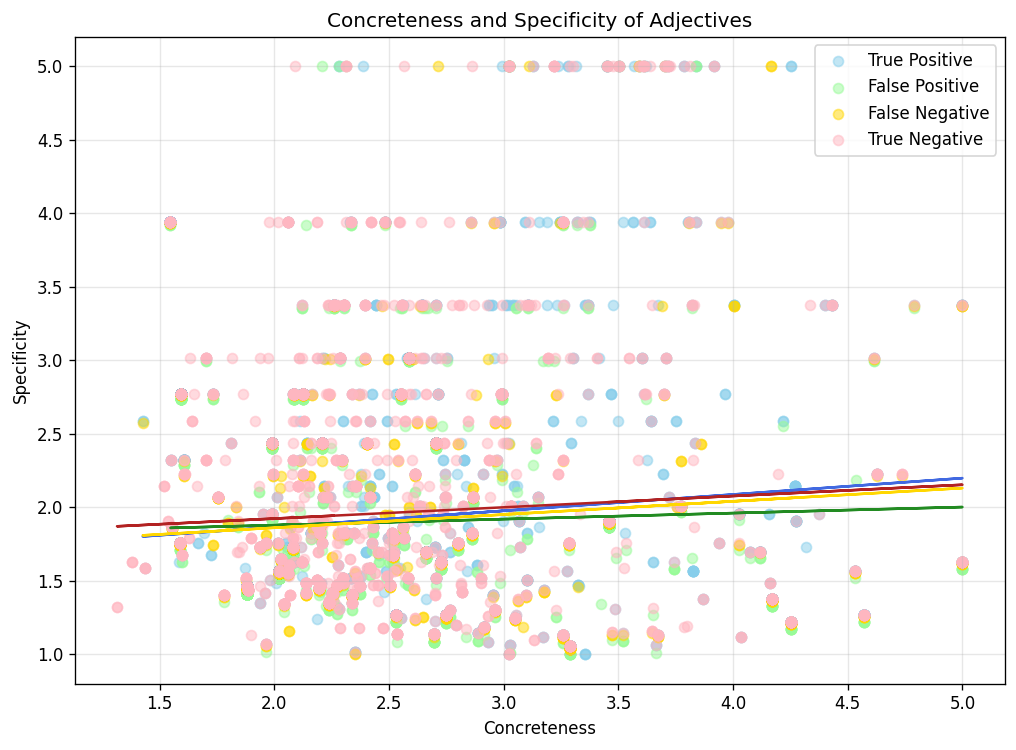

In [ ]:
data_names = ["True Positive", "False Positive", "False Negative", "True Negative"]
colors = ["skyblue", "palegreen", "gold", "lightpink"]
colors_line = ["royalblue", "forestgreen", "gold", "firebrick"]

fig, ax = plt.subplots(figsize=(10, 7), dpi=120)

for i, dataset in enumerate(all_conc_adj):
    m, b = np.polyfit(dataset, all_spec_adj[i], 1)
    ax.scatter(dataset, all_spec_adj[i], c=colors[i], label=data_names[i], alpha=0.5)
    ax.plot(dataset, m * np.array(dataset) + b, c=colors_line[i])

ax.legend()
ax.grid(True, alpha=0.3)

ax.set_xlabel("Concreteness", fontsize=10)
ax.set_ylabel("Specificity", fontsize=10)
ax.set_title("Concreteness and Specificity of Adjectives")

plt.savefig(f"{HEAD_DIR}/conc_spec_adj.pdf",bbox_inches="tight")
plt.show()